In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Specify the path to your pickle file
file_path = "evaluation_metrics/classification_metrics_list.pkl"
with open(file_path, "rb") as file:
    classification_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/regression_metrics_list.pkl"
with open(file_path, "rb") as file:
    regression_metrics_list = pickle.load(file)

file_path = "evaluation_metrics/collect_classification_results.pkl"
with open(file_path, "rb") as file:
    collect_classification_results = pickle.load(file)

file_path = "evaluation_metrics/collect_regression_results.pkl"
with open(file_path, "rb") as file:
    collect_regression_results = pickle.load(file)

In [3]:
def calculate_kfold_mean_and_std(metrics_list):
    df = pd.DataFrame(metrics_list)
    numeric_cols = df.select_dtypes(include=[float]).columns
    grouped_df = df.groupby(["id", "Model", "Combination"])[numeric_cols]
    mean_df = grouped_df.mean()
    std_df = grouped_df.std()
    mean_df.reset_index(inplace=True)
    mean_df.drop(columns="id", inplace=True)
    std_df.reset_index(inplace=True)
    std_df.drop(columns="id", inplace=True)
    return mean_df, std_df


# Calculate mean and std from metric using k-folds
class_mean, class_std = calculate_kfold_mean_and_std(classification_metrics_list)
reg_mean, reg_std = calculate_kfold_mean_and_std(regression_metrics_list)

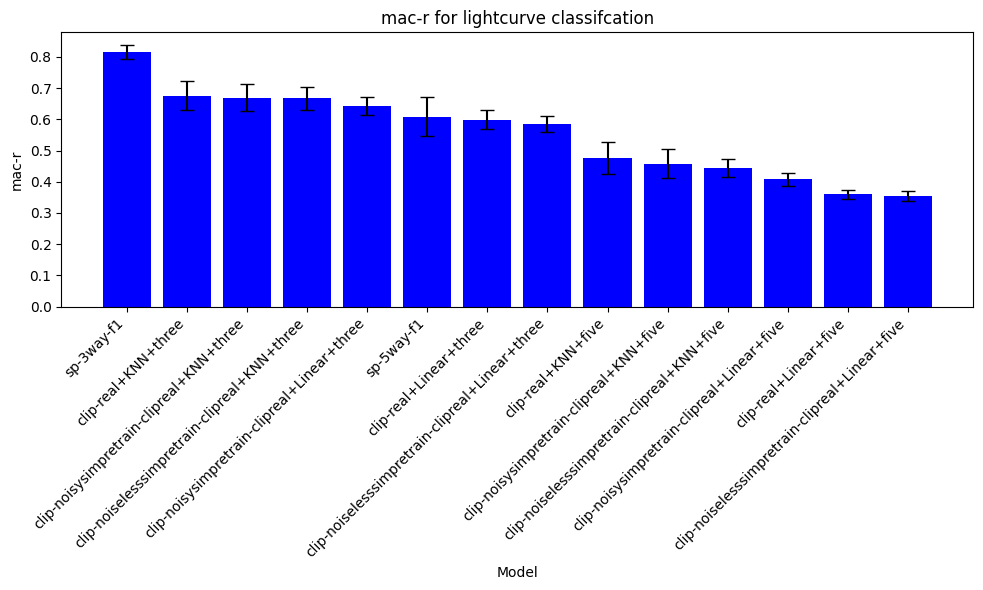

In [4]:
# Leaderboard in different metrics for classifications
variable_name = "mac-r"
lc_class_mean = class_mean[
    class_mean["Combination"] == "spectral"
]  # .drop(columns=dropcols)
lc_class_std = class_std[
    class_std["Combination"] == "spectral"
]  # .drop(columns=dropcols)
lc_class_mean = lc_class_mean.sort_values(by=variable_name, ascending=False)
lc_class_std = lc_class_std.loc[lc_class_mean.index]
plt.figure(figsize=(10, 6))
plt.bar(
    lc_class_mean["Model"],
    lc_class_mean[variable_name],
    yerr=lc_class_std[variable_name],
    capsize=5,
    color="blue",
)
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

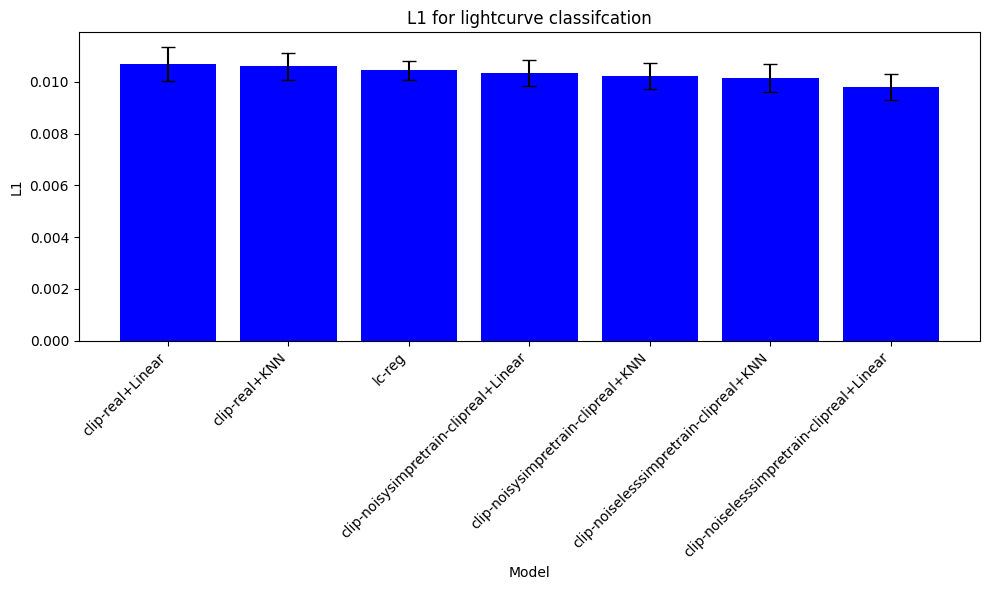

In [15]:
# dropcols = ['mic-f1', 'mic-p', 'mic-r', 'mic-acc','mac-f1', 'mac-p', 'mac-r', 'mac-acc']
variable_name = "L1"  # Choose [ L1	L2	R2	OLF]
lc_reg_mean = reg_mean[
    reg_mean["Combination"] == "lightcurve"
]  # .drop(columns=dropcols)
lc_reg_std = reg_std[reg_std["Combination"] == "lightcurve"]  # .drop(columns=dropcols)
lc_reg_mean = lc_reg_mean.sort_values(by=variable_name, ascending=False)
lc_reg_std = lc_reg_std.loc[lc_reg_mean.index]
plt.figure(figsize=(10, 6))
plt.bar(
    lc_reg_mean["Model"],
    lc_reg_mean[variable_name],
    yerr=lc_reg_std[variable_name],
    capsize=5,
    color="blue",
)
plt.xlabel("Model")
plt.ylabel(variable_name)
plt.title(f"{variable_name} for lightcurve classifcation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()